<a href="https://colab.research.google.com/github/mihaescurazvan/Sentiment-Analysis-in-Text/blob/master/SentimentAnalysisProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analyisis in Text

## Scope of the project 

The goal of this project is to train and evaluate machine learning and deep learning models to calssify the sentiment of tweets in the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) dataset from Kaggle.

## About the dataset

The Sentiment140 dataset contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. 
It contains the following 6 fields:

* target: the polarity of the tweet (0 = negative, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

## Setup


In [1]:
# importing some important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud ### For visualising the frequent words
import re
import random
import string
import math
import itertools

# To mute general warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout,GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix,classification_report
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# let's connect to google drive, where the dataset is stored
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define some meaningful constants:

In [3]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Exploratory Data Analysis

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)

In [5]:
# inspect the data
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The dataset does not contain the header, so it would be a good idea to rename the columns for more intuiton

In [6]:
# rename the columns 
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The scope of the project is a binary classification after all, so let's see if we are dealing with imbalanced data.

In [7]:
# analyze the classes
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

The classes are perfectly balanced, with an equal number of positive and negative tweets.

How many enteries are in the dataframe ?

In [8]:
# let's see how many rows do we have
print(f'There are {df.shape[0]} rows in the dataframe.')

There are 1600000 rows in the dataframe.


The dataset is huge, with 1.6 million samples. To save time, I am going to use only 10% of the data. 

## Data preprocessing


Because I want to do a pure NLP based project, I am going to keep only two columns: **text** and **sentiment**. The rest of the columns could me useful, for example, maybe I could find a realtion beetween the **user_id** and the **sentiment** (target column), but they are out of the scope of this project.

In [9]:
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


I will make a function that save the tweets and the sentiment in two lists and change the labels in 1 for POSITIVE and 0 for NEGATIVE.

In [10]:
def parse_data_from_dataframe(df):
  sentences = []
  labels = []
  for index, row in df.iterrows(): 
    labels.append(0 if row['sentiment']==0 else 1)
    sentences.append(row['text'])

  
  return sentences, labels

In [11]:
# test the function
sentences, labels = parse_data_from_dataframe(df)

print(f'There are {len(sentences)} tweets.\n')

print(f'Tweet of the second example should look like this:\n{sentences[1]}\n')
print(f'Labels of the last 5 tweets should be:\n{labels[-5:]}')

There are 1600000 tweets.

Tweet of the second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Labels of the last 5 tweets should be:
[1, 1, 1, 1, 1]


Next, I will shuffle the data and select only 10% of it for keeping a low execution time.

In [12]:
sentences_and_labels = list(zip(sentences, labels))
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)
sentences, labels = zip(*sentences_and_labels)
print(f'There are {len(sentences)} tweets and {len(labels)} labels after random sampling.')

There are 160000 tweets and 160000 labels after random sampling.


In [13]:
# make sure the classes are still balanced
from collections import Counter

counted = Counter(labels)
counted

Counter({1: 80178, 0: 79822})

## Text preprocessing

Tweets usually contain unnecessary data like **user mentions**, **hyperlinks** and **punctuations**. So, we need to clean them before training the model.

### **Removing Stopwords**

One important step is to remove **stopwords**. These are the most common words in the language and they do not provide useful information for the classification process.
I am going to define a function **remove stopwords** which recives a string and returns another one that excludes all of the stopwords.


In [14]:
def remove_stopwords(sentence):
  stopwords = ["a", "about", "above", "after", "again", "against", "all",
                "am", "an", "and", "any", "are", "as", "at", "be", "because",
                "been", "before", "being", "below", "between", "both", "but",
                "by", "could", "did", "do", "does", "doing", "down", "during",
                "each", "few", "for", "from", "further", "had", "has", "have",
                "having", "he", "he'd", "he'll", "he's", "her", "here", 
                "here's", "hers", "herself", "him", "himself", "his", "how", 
                "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", 
                "is", "it", "it's", "its", "itself", "let's", "me", "more", 
                "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
                "other", "ought", "our", "ours", "ourselves", "out", "over", 
                "own", "same", "she", "she'd", "she'll", "she's", "should", 
                "so", "some", "such", "than", "that", "that's", "the", "their",
                "theirs", "them", "themselves", "then", "there", "there's", 
                "these", "they", "they'd", "they'll", "they're", "they've", 
                "this", "those", "through", "to", "too", "under", "until", 
                "up", "very", "was", "we", "we'd", "we'll", "we're", "we've",
                "were", "what", "what's", "when", "when's", "where", "where's",
                "which", "while", "who", "who's", "whom", "why", "why's", 
                "with", "would", "you", "you'd", "you'll", "you're", "you've",
                "your", "yours", "yourself", "yourselves" ]
  sentence = sentence.lower()

  words = sentence.split()
  results_words = [ word for word in words if word not in stopwords ]
  sentence = ' '.join(results_words)
  return sentence

              


In [15]:
# remove the stopwords from the data
sentences = list(sentences)
for i in range(len(sentences)):
  sentences[i] = remove_stopwords(sentences[i])


print(sentences[:5])

['working new items, prepping photoshoot saturday. newest veil style reminds ghost pacman', 'hungry...waitin 4 take aways hour!', '@calzer nope, can agree one cal, dundee crap! win. nothing dump.', '@harley_dude hear people calling twitter tweeter. already answer people scripted', 'finished draft # 2 short script yesterday. today wrote pages another short. raining day']


### **Remove Hyperlinks and Mentions**

In [16]:
# view the number of tweets that contain Mentions

v=[]
for i in range(len(sentences)):
    v.append(re.findall(r'(@\S+)',sentences[i]))   
    
v1=[i for i in v if len(i)!=0]
print(f"There are {len(v1)} rows with Mentions(@hire_me) in their text")

There are 73636 rows with Mentions(@hire_me) in their text


In [17]:
# view the number of tweets that contain Hyperlinks

v=[]
for i in range(len(sentences)):
    v.append(re.findall(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])',sentences[i]))   

v2=[i for i in v if len(i)!=0]
print(f"There are {len(v2)} rows with Hyperlinks(http://hire-me.mihaescurazvan) in their text")

There are 6964 rows with Hyperlinks(http://hire-me.mihaescurazvan) in their text


In [18]:
print(v1[:5])
print(v2[:5])

[['@calzer'], ['@harley_dude'], ['@seasonsays...'], ['@legalcookie'], ['@brittanystreet']]
[[('http', 'bit.ly', '/6nro1')], [('http', 'is.gd', '/19dpc')], [('http', 'tinyurl.com', '/dhpol7')], [('http', 'ow.ly', '/apsj')], [('http', 'twitpic.com', '/69wk3')]]


In [19]:
# pattern removing Hyperlinks and Mentions:
pattern = "(@\S+)|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"

for i in range(len(sentences)):
  sentences[i] = re.sub(pattern, ' ', str(sentences[i]).lower()).strip()

print(sentences[:10])

['working new items, prepping photoshoot saturday. newest veil style reminds ghost pacman', 'hungry...waitin 4 take aways hour!', 'nope, can agree one cal, dundee crap! win. nothing dump.', 'hear people calling twitter tweeter. already answer people scripted', 'finished draft # 2 short script yesterday. today wrote pages another short. raining day', 'still gutted nkotb not coming australia...', "something nose, deep inside. annoying makes sneeze like hell. can't reach fuck shit", 'head jc basketball game embarrass me. nobody, not even brother, kick azz', 'really? ok wait read it!!!', 'no, ninny. supposed work pc. dont make fun bc macless']


### **Removing the punctuation**

In [20]:
## list of punctuation marks

list_punct = string.punctuation

for i in range(len(sentences)):
  sentences[i] = str(sentences[i]).translate(str.maketrans('', '', list_punct))

print(sentences[:10])

['working new items prepping photoshoot saturday newest veil style reminds ghost pacman', 'hungrywaitin 4 take aways hour', 'nope can agree one cal dundee crap win nothing dump', 'hear people calling twitter tweeter already answer people scripted', 'finished draft  2 short script yesterday today wrote pages another short raining day', 'still gutted nkotb not coming australia', 'something nose deep inside annoying makes sneeze like hell cant reach fuck shit', 'head jc basketball game embarrass me nobody not even brother kick azz', 'really ok wait read it', 'no ninny supposed work pc dont make fun bc macless']


Let's visulalize the most frequent words in tweets with WordCloud Plots.

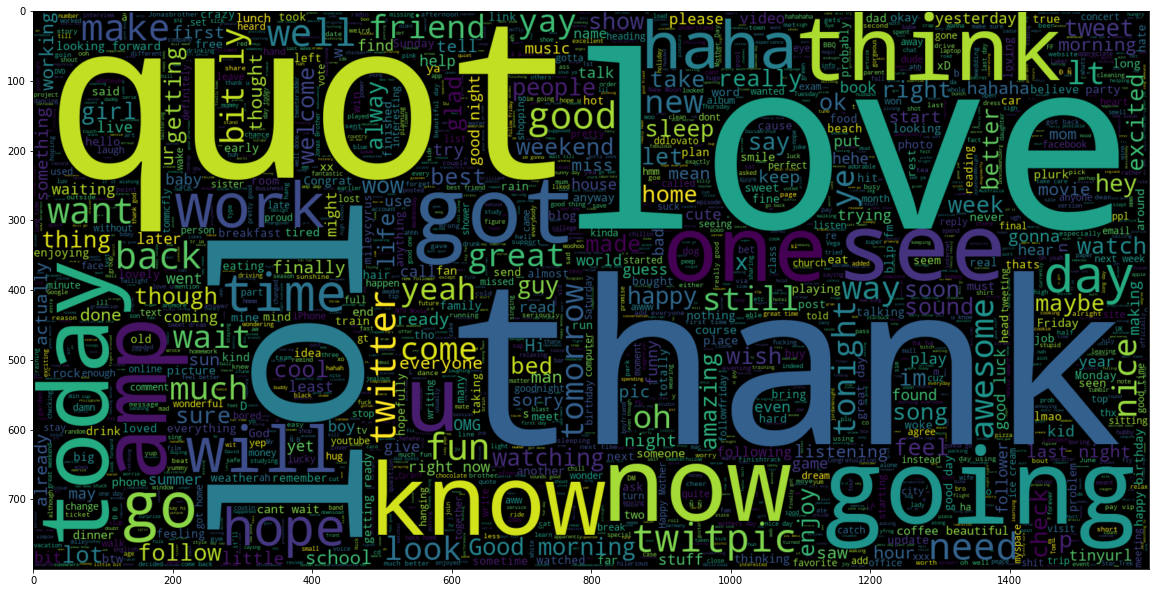

In [21]:
# plot top words from positive tweets

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 4].text))
plt.imshow(wc , interpolation = 'bilinear')

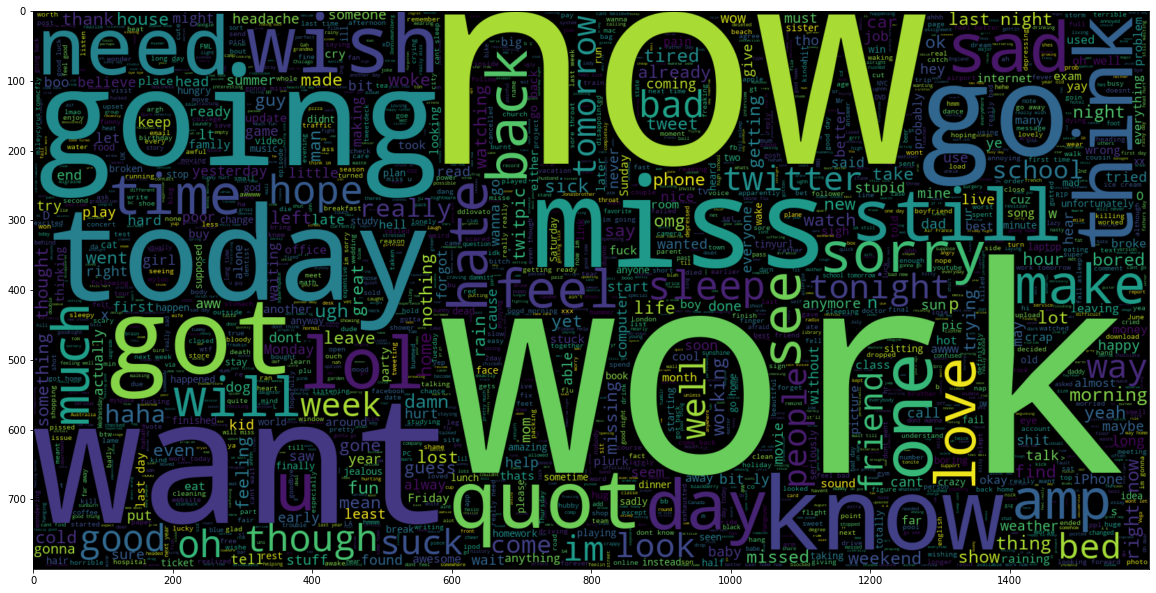

In [22]:
# plot top words from negative tweets

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

## Splitting in train, val and test sets

I will define a function **train_val_split** for splitting the data.

In [23]:
sentences = tuple(sentences)

In [24]:
def train_val_split(sentences, labels, training_split):
  train_size = int(len(sentences)*training_split)
  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  validation_sentences = sentences[train_size:]
  validation_labels = labels[train_size:]

  return train_sentences, validation_sentences, train_labels, validation_labels

In [25]:
# make the split
train_sentences, test_sentences, train_labels, test_labels = train_val_split(sentences, labels, TRAINING_SPLIT)
train_sentences, val_sentences, train_labels, val_labels = train_val_split(train_sentences, train_labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")
print(f"There are {len(test_sentences)} sentences for testing.\n")
print(f"There are {len(test_labels)} labels for testing.")

There are 129600 sentences for training.

There are 129600 labels for training.

There are 14400 sentences for validation.

There are 14400 labels for validation.
There are 16000 sentences for testing.

There are 16000 labels for testing.


In [26]:
counted = Counter(train_labels)
counted

Counter({1: 65082, 0: 64518})

In [27]:
counted = Counter(val_labels)
counted

Counter({0: 7204, 1: 7196})

In [28]:
counted = Counter(test_labels)
counted

Counter({0: 8100, 1: 7900})

The splits resulted in pretty balanced classes. That's good!

## Tokenization


A tokenizer creates tokens for every word in the data corpus and map them to a index using a dictionary. I will define the **fit_tokenizer** function which returns a **Tokenizer** that has been fitted to the training sentences.

In [29]:
def fit_tokenizer(train_sentences, oov_token):

  tokenizer = Tokenizer(oov_token=oov_token)
  tokenizer.fit_on_texts(train_sentences)
  return tokenizer

In [30]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 80951 words

<OOV> token included in vocabulary

index of word 'i' should be 488


I will use the method **texts_to_sequences** to convert the whole sentences to a vector representation and the **pad_sequences** to adjusts the size of the vectors, so that we get a uniformly spaced/sized vector. I will define the **seq_pad_and_trunc** for this.

In [31]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
  return pad_trunc_sequences

In [32]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
test_pad_trunc_seq = seq_pad_and_trunc(test_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")
print(f"Padded and truncated testing sequences have shape: {test_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (129600, 16)

Padded and truncated validation sequences have shape: (14400, 16)
Padded and truncated testing sequences have shape: (16000, 16)


In [33]:
train_pad_trunc_seq[0]

array([   90,    30,  3077,  7123,  3961,   305,  3962, 12552,  1611,
        1774,  2514,  8270,     0,     0,     0,     0], dtype=int32)

In [34]:
# convert the labels to numpy arrays so that we can use them in tensorflow models
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(train_labels)
print(val_labels)
print(test_labels)

[1 0 0 ... 1 1 1]
[0 0 1 ... 1 0 0]
[0 0 0 ... 1 1 0]


In [35]:
type(train_labels)

numpy.ndarray

## Vectorizing 

Word Embedding is one of the popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. 

In this project, I am going to use pre-trained word vectors. I will be using the 100 dimension version of **GloVe** (Global Vectors for Word Representation) by Stanford.

In [36]:
glove_file = '/content/drive/MyDrive/Sentiment Analysis Project/glove.6B.100d.txt'

glove_embeddings = {}

with open(glove_file) as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    glove_embeddings[word] = coefs

In [37]:
# let's see the embeddings for word 'love'

word = 'love'
vector = glove_embeddings[word]
print(f'Vector representation for word {word} is:\n\n{vector}')

Vector representation for word love is:

[ 2.5975e-01  5.5833e-01  5.7986e-01 -2.1361e-01  1.3084e-01  9.4385e-01
 -4.2817e-01 -3.7420e-01 -9.4499e-02 -4.3344e-01 -2.0937e-01  3.4702e-01
  8.2516e-02  7.9735e-01  1.6606e-01 -2.6878e-01  5.8830e-01  6.7397e-01
 -4.9965e-01  1.4764e+00  5.5261e-01  2.5295e-02 -1.6068e-01 -1.3878e-01
  4.8686e-01  1.1420e+00  5.6195e-02 -7.3306e-01  8.6932e-01 -3.5892e-01
 -5.1877e-01  9.0402e-01  4.9249e-01 -1.4915e-01  4.8493e-02  2.6096e-01
  1.1352e-01  4.1275e-01  5.3803e-01 -4.4950e-01  8.5733e-02  9.1184e-02
  5.0177e-03 -3.4645e-01 -1.1058e-01 -2.2235e-01 -6.5290e-01 -5.1838e-02
  5.3791e-01 -8.1040e-01 -1.8253e-01  2.4194e-01  5.4855e-01  8.7731e-01
  2.2165e-01 -2.7124e+00  4.9405e-01  4.4703e-01  5.5882e-01  2.6076e-01
  2.3760e-01  1.0668e+00 -5.6971e-01 -6.4960e-01  3.3511e-01  3.4609e-01
  1.1033e+00  8.5261e-02  2.4847e-02 -4.5453e-01  7.7012e-02  2.1321e-01
  1.0444e-01  6.7157e-02 -3.4261e-01  8.5534e-01  1.3361e-01 -4.3296e-01
 -5.6726e-

I will be computing the **embedding_matrix** that contains the vector representations for each word int the vocabulary. If a word from the vocab is not in the **glove_embeddings**, it will be representing by zeros.

In [38]:
embeddings_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

for word, i in word_index.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector

## Text Classification using RNNs

I am going to train two models that use LMSTs, one that uses only RNN and Dense layers and one that combines Convolutional layers with Pooling layers.

In [39]:
# first model 
model = Sequential([
    Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embeddings_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [40]:
# compile model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           8095200   
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [42]:
# train model
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4050/4050 [==============================] - 62s 13ms/step - loss: 0.5218 - accuracy: 0.7393 - val_loss: 0.4842 - val_accuracy: 0.7645
Epoch 2/20
4050/4050 [==============================] - 53s 13ms/step - loss: 0.4709 - accuracy: 0.7759 - val_loss: 0.4772 - val_accuracy: 0.7685
Epoch 3/20
4050/4050 [==============================] - 45s 11ms/step - loss: 0.4469 - accuracy: 0.7905 - val_loss: 0.4656 - val_accuracy: 0.7758
Epoch 4/20
4050/4050 [==============================] - 42s 10ms/step - loss: 0.4254 - accuracy: 0.8025 - val_loss: 0.4633 - val_accuracy: 0.7791
Epoch 5/20
4050/4050 [==============================] - 42s 10ms/step - loss: 0.4031 - accuracy: 0.8152 - val_loss: 0.4706 - val_accuracy: 0.7810
Epoch 6/20
4050/4050 [==============================] - 42s 10ms/step - loss: 0.3778 - accuracy: 0.8287 - val_loss: 0.4884 - val_accuracy: 0.7795
Epoch 7/20
4050/4050 [==============================] - 43s 11ms/step - loss: 0.3523 - accuracy: 0.8429 - val_loss: 0.5046 -

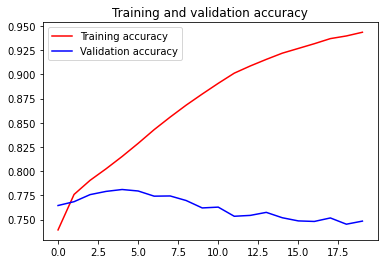

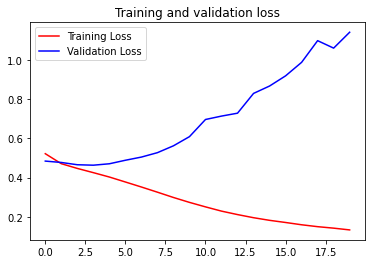

In [43]:
# let's see some infos about the training history
# we will look at the accuracy and loss on both training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# we should evaluate the model on the test set
test_loss = model.evaluate(test_pad_trunc_seq, test_labels)

500/500 [==============================] - 2s 5ms/step - loss: 1.1542 - accuracy: 0.7476


In [45]:
# make predictions 
def decode_sentiment(score):
  return 1 if score>0.5 else 0


scores = model.predict(test_pad_trunc_seq)
preds = [decode_sentiment(score) for score in scores]

500/500 [==============================] - 3s 4ms/step


In [46]:
# display the results on test
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(test_labels, preds)))
print('\n')
print(classification_report(test_labels, preds))

Accuracy: 0.747625


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      8100
           1       0.74      0.76      0.75      7900

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000



In [47]:
# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=test_labels,                                      
    y_pred=preds))  
print(confusionMatrix)

[[5984 2116]
 [1922 5978]]


In [48]:
# save the model in the project directory 
model.save("/content/drive/MyDrive/Sentiment Analysis Project/first_model.h5")

We see that the model performs pretty good on the training set, with over **90% accuracy**, but on test and validation does poorly. This is a clear sign of **overfitting**.
Next, I will define a model that does not overfit.

In [49]:
# second model 
model = Sequential([
    Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embeddings_matrix], trainable=False),
    Dropout(0.2),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [50]:
# compile model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 100)           8095200   
                                                                 
 dropout_1 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            16032     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

In [53]:
# train model
history = model.fit(train_pad_trunc_seq, train_labels, epochs=50, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4727 - accuracy: 0.7718 - val_loss: 0.5003 - val_accuracy: 0.7540
Epoch 2/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4726 - accuracy: 0.7724 - val_loss: 0.4976 - val_accuracy: 0.7549
Epoch 3/50
4050/4050 [==============================] - 16s 4ms/step - loss: 0.4716 - accuracy: 0.7730 - val_loss: 0.4984 - val_accuracy: 0.7541
Epoch 4/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4719 - accuracy: 0.7725 - val_loss: 0.4975 - val_accuracy: 0.7515
Epoch 5/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4708 - accuracy: 0.7724 - val_loss: 0.4997 - val_accuracy: 0.7543
Epoch 6/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4683 - accuracy: 0.7752 - val_loss: 0.5037 - val_accuracy: 0.7560
Epoch 7/50
4050/4050 [==============================] - 14s 4ms/step - loss: 0.4698 - accuracy: 0.7735 - val_loss: 0.4982 - val_ac

In [54]:
# we should evaluate the model on the test set
test_loss = model.evaluate(test_pad_trunc_seq, test_labels)

500/500 [==============================] - 2s 3ms/step - loss: 0.5012 - accuracy: 0.7589


In [55]:
scores = model.predict(test_pad_trunc_seq)
preds = [decode_sentiment(score) for score in scores]

500/500 [==============================] - 1s 2ms/step


In [56]:
# display the results on test
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(test_labels, preds)))
print('\n')
print(classification_report(test_labels, preds))

Accuracy: 0.758875


              precision    recall  f1-score   support

           0       0.77      0.75      0.76      8100
           1       0.75      0.77      0.76      7900

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000



In [57]:
# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=test_labels,                                      
    y_pred=preds))  
print(confusionMatrix)

[[6082 2018]
 [1840 6060]]


In [58]:
# save the model in the project directory 
model.save("/content/drive/MyDrive/Sentiment Analysis Project/second_model.h5")

We can say that this model, does not overfit, but it still does not get a great performance. Let's see if we cand combine the to models to achive better results.

In [62]:
# third model 
model = Sequential([
    Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embeddings_matrix], trainable=False),
    Bidirectional(LSTM(32, return_sequences=True)),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [63]:
# compile model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 16, 100)           8095200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 16, 64)           34048     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 32)            10272     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [65]:
# train model
history = model.fit(train_pad_trunc_seq, train_labels, epochs=50, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/50
4050/4050 [==============================] - 36s 8ms/step - loss: 0.5246 - accuracy: 0.7378 - val_loss: 0.4960 - val_accuracy: 0.7578
Epoch 2/50
4050/4050 [==============================] - 33s 8ms/step - loss: 0.4734 - accuracy: 0.7746 - val_loss: 0.4699 - val_accuracy: 0.7740
Epoch 3/50
4050/4050 [==============================] - 31s 8ms/step - loss: 0.4531 - accuracy: 0.7869 - val_loss: 0.4666 - val_accuracy: 0.7765
Epoch 4/50
4050/4050 [==============================] - 30s 7ms/step - loss: 0.4359 - accuracy: 0.7965 - val_loss: 0.4668 - val_accuracy: 0.7786
Epoch 5/50
4050/4050 [==============================] - 31s 8ms/step - loss: 0.4202 - accuracy: 0.8057 - val_loss: 0.4719 - val_accuracy: 0.7789
Epoch 6/50
4050/4050 [==============================] - 31s 8ms/step - loss: 0.4049 - accuracy: 0.8130 - val_loss: 0.4723 - val_accuracy: 0.7769
Epoch 7/50
4050/4050 [==============================] - 30s 8ms/step - loss: 0.3915 - accuracy: 0.8203 - val_loss: 0.4780 - val_ac

In [66]:
# we should evaluate the model on the test set
test_loss = model.evaluate(test_pad_trunc_seq, test_labels)

500/500 [==============================] - 2s 4ms/step - loss: 1.2112 - accuracy: 0.7418


In [67]:
scores = model.predict(test_pad_trunc_seq)
preds = [decode_sentiment(score) for score in scores]

500/500 [==============================] - 2s 3ms/step


In [68]:
# display the results on test
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(test_labels, preds)))
print('\n')
print(classification_report(test_labels, preds))

Accuracy: 0.7418125


              precision    recall  f1-score   support

           0       0.74      0.75      0.75      8100
           1       0.74      0.73      0.74      7900

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



In [69]:
# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=test_labels,                                      
    y_pred=preds))  
print(confusionMatrix)

[[6092 2008]
 [2123 5777]]


In [70]:
# save the model in the project directory 
model.save("/content/drive/MyDrive/Sentiment Analysis Project/third_model.h5")

## Transfer learning - **BERT**

BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks. 

I am going to user a smaller version of BERT: **smallBERT**

In [72]:
# A dependency of the preprocessing for BERT inputs
! pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 81.0 MB/s eta 0:00:00


In [73]:
! pip install -q tf-models-official==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [74]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [75]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [76]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [77]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [78]:
# define the model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [80]:
# test if the model runs
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(["I did not like Antman Quantummania"]))
print(bert_raw_result)

tf.Tensor([[0.803527]], shape=(1, 1), dtype=float32)


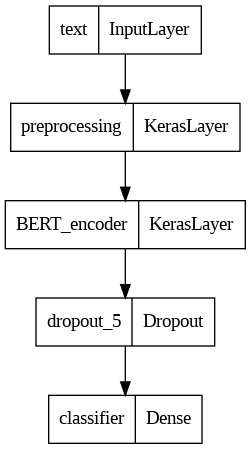

In [81]:
# take a look at the model structure 
tf.keras.utils.plot_model(classifier_model)

In [82]:
# defining the loss and the metric
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

In [84]:
epochs = 10
steps_per_epoch = len(train_sentences)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [85]:
# compile the model 
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [87]:
# training the model
train_sentences = np.array(train_sentences)
val_sentences = np.array(val_sentences)
test_sentences = np.array(test_sentences)
history = classifier_model.fit(train_sentences, train_labels, epochs=epochs, validation_data=(val_sentences, val_labels))

Epoch 1/10
4050/4050 [==============================] - 1045s 256ms/step - loss: 0.6674 - binary_accuracy: 0.6025 - val_loss: 0.5541 - val_binary_accuracy: 0.7149
Epoch 2/10
4050/4050 [==============================] - 1039s 256ms/step - loss: 0.5356 - binary_accuracy: 0.7326 - val_loss: 0.4938 - val_binary_accuracy: 0.7615
Epoch 3/10
4050/4050 [==============================] - 1026s 253ms/step - loss: 0.4927 - binary_accuracy: 0.7626 - val_loss: 0.4746 - val_binary_accuracy: 0.7760
Epoch 4/10
4050/4050 [==============================] - 1037s 256ms/step - loss: 0.4687 - binary_accuracy: 0.7780 - val_loss: 0.4488 - val_binary_accuracy: 0.7892
Epoch 5/10
4050/4050 [==============================] - 1063s 262ms/step - loss: 0.4503 - binary_accuracy: 0.7908 - val_loss: 0.4411 - val_binary_accuracy: 0.7953
Epoch 6/10
4050/4050 [==============================] - 1024s 253ms/step - loss: 0.4335 - binary_accuracy: 0.7997 - val_loss: 0.4381 - val_binary_accuracy: 0.8006
Epoch 7/10
4050/4050 [

In [89]:
# we should evaluate the model on the test set
test_loss = classifier_model.evaluate(test_sentences, test_labels)

500/500 [==============================] - 57s 114ms/step - loss: 0.4639 - binary_accuracy: 0.8018


In [90]:
scores = classifier_model.predict(test_sentences)
preds = [decode_sentiment(score) for score in scores]

500/500 [==============================] - 55s 109ms/step


In [91]:
# display the results on test
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(test_labels, preds)))
print('\n')
print(classification_report(test_labels, preds))

Accuracy: 0.8018125


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      8100
           1       0.81      0.77      0.79      7900

    accuracy                           0.80     16000
   macro avg       0.80      0.80      0.80     16000
weighted avg       0.80      0.80      0.80     16000



In [92]:
# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=test_labels,                                      
    y_pred=preds))  
print(confusionMatrix)

[[6709 1391]
 [1780 6120]]


### Make a prediction

I have choosed a tweet about the NBA All-Star Weekend 2023([tweet](https://twitter.com/3blezd/status/1627150909955510273)) and I will test how the model will score the sentiment in this text.

In [98]:
tweet_text = "White man CAN JUMP✈️ #AllStarWeekend2023"
bert_result = classifier_model(tf.constant([tweet_text]))
print(bert_result)

tf.Tensor([[0.9451281]], shape=(1, 1), dtype=float32)


Nice, the model score this tweet with 94% positivity!

In [99]:
# save the model in the project directory 
classifier_model.save("/content/drive/MyDrive/Sentiment Analysis Project/bert_model.h5")

## Conclusions 


**Recurrent Neural Networks are dead, long live Transformers**. 
As expected, BERT gave us the best performance. The scope of the project has been achived, by experiencing multiple techniques on working with text data: text preprocessing (removing stopwords, hpyerlinks, mentions and punctuations), tokenization, vectorizing  (using pre-trained word embeddings from GloVe), training multiple deep learning models.